## Imports

In [324]:
import io
import pathlib
import pickle
import re
import pandas as pd
pd.set_option('display.max_rows', None)

import ads
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
import galstreams
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

from astropy.stats import median_absolute_deviation as MAD
from gala.units import galactic
# from helpers import (
#     get_default_track_for_stream,
#     get_frame_from_points,
#     get_full_galstreams_poly,
#     get_isochrone,
#     make_ibata_poly_nodes,
#     run_orbit_fit,
# )
from pyia import GaiaData
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import minimize
from tqdm.auto import tqdm

from astropy.table import Table, vstack, hstack, join, unique

from astroquery.gaia import Gaia
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source" # Select Data Release 3

import time

%matplotlib inline

In [325]:
galcen_frame = coord.Galactocentric(
    galcen_distance=8.275 * u.kpc, galcen_v_sun=[8.4, 251, 8.4] * u.km / u.s
)
mw = gp.MilkyWayPotential2022()

In [8]:
mwstreams = galstreams.MWStreams(implement_Off=True)

Initializing galstreams library from master_log... 


In [827]:
mwstreams

{'20.0-1-M18': <galstreams.core.Track6D at 0x7f7b5c164880>,
 '300S-F18': <galstreams.core.Track6D at 0x7f7b5c15efa0>,
 'AAU-ATLAS-L21': <galstreams.core.Track6D at 0x7f7b05aedaf0>,
 'AAU-AliqaUma-L21': <galstreams.core.Track6D at 0x7f7b5c1618b0>,
 'ACS-R21': <galstreams.core.Track6D at 0x7f7b5c181be0>,
 'ATLAS-I21': <galstreams.core.Track6D at 0x7f7b05ae5d30>,
 'ATLAS-I24': <galstreams.core.Track6D at 0x7f7b2044b550>,
 'Acheron-G09': <galstreams.core.Track6D at 0x7f7b05a91880>,
 'Alpheus-G13': <galstreams.core.Track6D at 0x7f7b059a7250>,
 'Aquarius-W11': <galstreams.core.Track6D at 0x7f7b05ae5b80>,
 'C-10-I24': <galstreams.core.Track6D at 0x7f7b05a57c40>,
 'C-11-I24': <galstreams.core.Track6D at 0x7f7b03718a90>,
 'C-12-I24': <galstreams.core.Track6D at 0x7f7b057c1820>,
 'C-13-I24': <galstreams.core.Track6D at 0x7f7b0595c7f0>,
 'C-19-I21': <galstreams.core.Track6D at 0x7f7b059b5d30>,
 'C-19-I24': <galstreams.core.Track6D at 0x7f7b034b6a30>,
 'C-20-I24': <galstreams.core.Track6D at 0x7f7

In [112]:
names = ['20.0-1', '300S', 'ATLAS-Aliqa Uma', 'Acheron',
       'Alpheus', 'Aquarius', 'C-10', 'C-11', 'C-12', 'C-13', 'C-19',
       'C-20', 'C-22', 'C-23', 'C-24', 'C-25', 'C-4', 'C-5', 'C-7', 'C-8',
       'C-9', 'Cetus-Palca', 'Cocytos', 'Corvus',
       'Elqui', 'Eridanus', 'GD-1', 'Gaia-1', 
       'Gaia-11', 'Gaia-12', 'Gaia-2', 'Gaia-3', 'Gaia-4', 'Gaia-5',
       'Gaia-6', 'Gaia-7', 'Gaia-8', 'Gaia-9', 'Gunnthra', 'Hermus',
       'Hrid', 'Hydrus', 'Hyllus', 'Indus', 'Jet', 'Jhelum',
       'Kshir', 'Kwando', 'Wukong', 'Leiptr', 'Lethe', 'M2',
       'M3', 'M30', 'M5', 'M68', 'M92', 'Molonglo',
       'Murrumbidgee', 'NGC 1261',
       'NGC 1851', 'NGC 2298', 'NGC 2808', 'NGC 288', 'NGC 3201',
       'NGC 5053', 'NGC 5466', 'NGC 5824', 'NGC 6101', 'NGC 6362',
       'NGC 6397', 'NGC 7492', 'New-1', 'New-10', 'New-11', 'New-12',
       'New-13', 'New-14', 'New-15', 'New-16', 'New-17', 'New-18',
       'New-19', 'New-2', 'New-20', 'New-21', 'New-22', 'New-23',
       'New-24', 'New-25', 'New-26', 'New-27', 'New-3', 'New-4', 'New-5',
       'New-6', 'New-7', 'New-8', 'New-9', 'Omega Centauri',
       'Ophiuchus', 'Orinoco', 'Orphan-Chenab', 'PS1-A', 'PS1-B', 'PS1-C',
       'PS1-D', 'PS1-E', 'Palomar 13', 'Palomar 15', 'Palomar 5',  'Parallel',
       'Pegasus', 'Perpendicular', 'Phlegethon', 'Phoenix', 'Ravi',
       'SGP-S', 'Sagittarius', 'Sangarius', 'Scamander', 'Slidr',
       'Spectre', 'Styx', 'Sylgr', 'Tucana III',
       'Turbio', 'Turranburra', 'Wambelong', 'Willka Yaku', 'Ylgr']

In [828]:
# translate stream names to galstreams
dict_invgalstreams = {'20.0-1':'20.0-1-M18', '300S':'300S-F18', 'ATLAS-Aliqa Uma':'AAU-ATLAS-L21',
                      'Acheron':'Acheron-G09', 'Alpheus':'Alpheus-G13', 'Aquarius':'Aquarius-W11', 'C-10':'C-10-I24',
                      'C-11':'C-11-I24', 'C-12':'C-12-I24', 'C-13':'C-13-I24', 'C-19':'C-19-I21', 'C-20':'C-20-I24',
                      'C-22':'C-22-I24', 'C-23':'C-23-I24', 'C-24':'C-24-I24', 'C-25':'C-25-I24', 'C-4':'C-4-I21',
                      'C-5':'C-5-I21', 'C-7':'C-7-I21', 'C-8':'C-8-I21', 'C-9':'C-9-I24',
                      'Cetus-Palca':'Cetus-Palca-T21', 'Cocytos':'Cocytos-G09', 'Corvus':'Corvus-M18',
                      'Elqui':'Elqui-S19', 'Eridanus':'Eridanus-M17', 'GD-1':'GD-1-PB18', 'Gaia-1':'Gaia-1-I21',
                      'Gaia-11':'Gaia-11-I21', 'Gaia-12':'Gaia-12-I21', 'Gaia-2':'Gaia-2-I21', 'Gaia-3':'Gaia-3-M18',
                      'Gaia-4':'Gaia-4-M18', 'Gaia-5':'Gaia-5-M18', 'Gaia-6':'Gaia-6-I21', 'Gaia-7':'Gaia-7-I21',
                      'Gaia-8':'Gaia-8-I21', 'Gaia-9':'Gaia-9-I21', 'Gunnthra':'Gunnthra-I21', 'Hermus':'Hermus-G14',
                      'Hrid':'Hrid-I21', 'Hydrus':'Hydrus-I24', 'Hyllus':'Hyllus-G14', 'Indus':'Indus-S19',
                      'Jet':'Jet-F22', 'Jhelum':'Jhelum-a-B19', 'Kshir':'Kshir-I21', 'Kwando':'Kwando-I21',
                      'Wukong':'LMS1-Y20', 'Leiptr':'Leiptr-I21', 'Lethe':'Lethe-G09', 'M2':'M2-I21', 'M3':'M3-Y23',
                      'M30':'M30-S20', 'M5':'M5-G19', 'M68':'M68-P19', 'M92':'M92-I21', 'Molonglo':'Molonglo-G17',
                      'Murrumbidgee':'Murrumbidgee-G17', 'NGC 1261':'NGC1261-I21', 'NGC 1851':'NGC1851-I21',
                      'NGC 2298':'NGC2298-I21', 'NGC 2808':'NGC2808-I24', 'NGC 288':'NGC288-I21',
                      'NGC 3201':'NGC3201-P21', 'NGC 5053':'NGC5053-L06', 'NGC 5466':'NGC5466-J21',
                      'NGC 5824':'Tri-Pis-B12',
                      'NGC 6101':'NGC6101-I24', 'NGC 6362':'NGC6362-S20', 'NGC 6397':'NGC6397-I21',
                      'NGC 7492':'NGC7492-I24', 'New-1':'New-1-I24', 'New-10':'New-10-I24', 'New-11':'New-11-I24',
                      'New-12':'New-12-I24', 'New-13':'New-13-I24', 'New-14':'New-14-I24', 'New-15':'New-15-I24',
                      'New-16':'New-16-I24', 'New-17':'New-17-I24', 'New-18':'New-18-I24', 'New-19':'New-19-I24',
                      'New-2':'New-2-I24', 'New-20':'New-20-I24', 'New-21':'New-21-I24', 'New-22':'New-22-I24',
                      'New-23':'New-23-I24', 'New-24':'New-24-I24', 'New-25':'New-25-I24', 'New-26':'New-26-I24',
                      'New-27':'New-27-I24', 'New-3':'New-3-I24', 'New-4':'New-4-I24', 'New-5':'New-5-I24',
                      'New-6':'New-6-I24', 'New-7':'New-7-I24', 'New-8':'New-8-I24', 'New-9':'New-9-I24',
                      'Omega Centauri':'OmegaCen-I21', 'Ophiuchus':'Ophiuchus-C20', 'Orinoco':'Orinoco-G17',
                      'Orphan-Chenab':'Orphan-K23', 'PS1-A':'PS1-A-B16', 'PS1-B':'PS1-B-B16', 'PS1-C':'PS1-C-B16',
                      'PS1-D':'PS1-D-B16', 'PS1-E':'PS1-E-B16', 'Palomar 13':'Pal13-S20', 'Palomar 15':'Pal15-M17',
                      'Palomar 5':'Pal5-PW19', 'Parallel':'Parallel-W18', 'Pegasus':'Pegasus-P19',
                      'Perpendicular':'Perpendicular-W18', 'Phlegethon':'Phlegethon-I21', 'Phoenix':'Phoenix-S19',
                      'Ravi':'Ravi-S18', 'SGP-S':'SGP-S-Y22', 'Sagittarius':'Sagittarius-A20',
                      'Sangarius':'Sangarius-G17', 'Scamander':'Scamander-G17', 'Slidr':'Slidr-I21',
                      'Spectre':'Spectre-C22', 'Styx':'Styx-G09', 'Sylgr':'Sylgr-I21',
                      'Tucana III':'TucanaIII-S19', 'Turbio':'Turbio-S18', 'Turranburra':'Turranburra-S19',
                      'Wambelong':'Wambelong-S18', 'Willka Yaku':'Willka_Yaku-S18', 'Ylgr':'Ylgr-I21'}

In [215]:
member_origin = {'20.0-1':[], '300S':['Ibata2024'], 'ATLAS-Aliqa Uma':['Ibata2024','Li2021','Shipp2019'],
                 'Acheron':[], 'Alpheus':[], 'Aquarius':[], 'C-10':['Ibata2024'], 'C-11':['Ibata2024'],
                 'C-12':['Ibata2024'], 'C-13':['Ibata2024'], 'C-19':['Ibata2024'], 'C-20':['Ibata2024'],
                 'C-22':['Ibata2024'], 'C-23':['Ibata2024'], 'C-24':['Ibata2024'], 'C-25':['Ibata2024'], 'C-4':[],
                 'C-5':[], 'C-7':['Ibata2024'], 'C-8':[], 'C-9':['Ibata2024'], 'Cetus-Palca':['Li2021'],
                 'Cocytos':[], 'Corvus':[], 'Elqui':['Shipp2019'], 'Eridanus':[],
                 'GD-1':['Huang2019','Bonaca2020','Ibata2024'], 'Gaia-1':['Ibata2024'], 'Gaia-11':['Ibata2024'],
                 'Gaia-12':['Ibata2024'], 'Gaia-2':[], 'Gaia-3':[], 'Gaia-4':[], 'Gaia-5':[], 'Gaia-6':['Ibata2024'],
                 'Gaia-7':['Ibata2024'], 'Gaia-8':['Ibata2024'], 'Gaia-9':['Ibata2024'], 'Gunnthra':[], 'Hermus':[],
                 'Hrid':['Ibata2024'], 'Hydrus':['Ibata2024'], 'Hyllus':[], 'Indus':['Ibata2024', 'Shipp2019'],
                 'Jet':['Ferguson2022'], 'Jhelum':['Ibata2024','Shipp2019'], 'Kshir':['Ibata2024'],
                 'Kwando':['Ibata2024'], 'Wukong':['Ibata2024'], 'Leiptr':['Ibata2024'], 'Lethe':[],
                 'M2':['Grillmair2022', 'Ibata2024'], 'M3':['Ibata2024','Yang2023'], 'M30':['Ibata2024'],
                 'M5':['Grillmair2019','Ibata2024'], 'M68':['Ibata2024'], 'M92':['Ibata2024'], 'Molonglo':[],
                 'Murrumbidgee':[], 'NGC 1261':['Ibata2024'], 'NGC 1851':['Ibata2024'], 'NGC 2298':['Ibata2024'],
                 'NGC 2808':['Ibata2024'], 'NGC 288':['Ibata2024'], 'NGC 3201':['Ibata2024'], 'NGC 5053':[],
                 'NGC 5466':['Ibata2024'], 'NGC 5824':['Yang2022'], 'NGC 6101':['Ibata2024'], 'NGC 6362':[],
                 'NGC 6397':['Ibata2024'], 'NGC 7492':['Ibata2024'], 'New-1':['Ibata2024'], 'New-10':['Ibata2024'],
                 'New-11':['Ibata2024'], 'New-12':['Ibata2024'], 'New-13':['Ibata2024'], 'New-14':['Ibata2024'],
                 'New-15':['Ibata2024'], 'New-16':['Ibata2024'], 'New-17':['Ibata2024'], 'New-18':['Ibata2024'],
                 'New-19':['Ibata2024'], 'New-2':['Ibata2024'], 'New-20':['Ibata2024'], 'New-21':['Ibata2024'],
                 'New-22':['Ibata2024'], 'New-23':['Ibata2024'], 'New-24':['Ibata2024'], 'New-25':['Ibata2024'],
                 'New-26':['Ibata2024'], 'New-27':['Ibata2024'], 'New-3':['Ibata2024'], 'New-4':['Ibata2024'],
                 'New-5':['Ibata2024'], 'New-6':['Ibata2024'], 'New-7':['Ibata2024'], 'New-8':['Ibata2024'],
                 'New-9':['Ibata2024'], 'Omega Centauri':['Ibata2024'], 'Ophiuchus':['Ibata2024'], 'Orinoco':[],
                 'Orphan-Chenab':['Shipp2019','Ibata2024','Koposov2023'], 'PS1-A':[], 'PS1-B':[], 'PS1-C':[],
                 'PS1-D':[], 'PS1-E':[], 'Palomar 13':['Shipp2020'], 'Palomar 15':[], 'Palomar 5':['Ibata2024'],
                 'Parallel':[], 'Pegasus':[], 'Perpendicular':[], 'Phlegethon':['Ibata2024'],
                 'Phoenix':['Ibata2024','Shipp2019'], 'Ravi':[], 'SGP-S':['Ibata2024'], 'Sagittarius':['Vasiliev2021'],
                 'Sangarius':[], 'Scamander':[], 'Slidr':['Ibata2024'], 'Spectre':['Chandra2022'], 'Styx':[],
                 'Sylgr':['Ibata2024'], 'Tucana III':['Ibata2024','Shipp2019'],
                 'Turbio':[], 'Turranburra':['Shipp2019'], 'Wambelong':[], 'Willka Yaku':[], 'Ylgr':['Ibata2024']}

In [122]:
# list of streams with published members
published = []
for stream in names[:]:
    catalogs = member_origin[stream]

    if len(catalogs)>0:
        published += [stream]

In [124]:
print(published)

['300S', 'ATLAS-Aliqa Uma', 'C-10', 'C-11', 'C-12', 'C-13', 'C-19', 'C-20', 'C-22', 'C-23', 'C-24', 'C-25', 'C-7', 'C-9', 'Cetus-Palca', 'Elqui', 'GD-1', 'Gaia-1', 'Gaia-11', 'Gaia-12', 'Gaia-6', 'Gaia-7', 'Gaia-8', 'Gaia-9', 'Hrid', 'Hydrus', 'Indus', 'Jet', 'Jhelum', 'Kshir', 'Kwando', 'Wukong', 'Leiptr', 'M2', 'M3', 'M30', 'M5', 'M68', 'M92', 'NGC 1261', 'NGC 1851', 'NGC 2298', 'NGC 2808', 'NGC 288', 'NGC 3201', 'NGC 5466', 'NGC 5824', 'NGC 6101', 'NGC 6397', 'NGC 7492', 'New-1', 'New-10', 'New-11', 'New-12', 'New-13', 'New-14', 'New-15', 'New-16', 'New-17', 'New-18', 'New-19', 'New-2', 'New-20', 'New-21', 'New-22', 'New-23', 'New-24', 'New-25', 'New-26', 'New-27', 'New-3', 'New-4', 'New-5', 'New-6', 'New-7', 'New-8', 'New-9', 'Omega Centauri', 'Ophiuchus', 'Orphan-Chenab', 'Palomar 13', 'Palomar 5', 'Phlegethon', 'Phoenix', 'SGP-S', 'Sagittarius', 'Slidr', 'Spectre', 'Sylgr', 'Tucana III', 'Turranburra', 'Ylgr']


## Fit orbit

In [919]:
def get_w0_from_p(p, phi1_init, frame):
    # At phi1 = 0.
    orbit_w0_fr = coord.SkyCoord(
        phi1=phi1_init,
        phi2=p["phi2"] * u.deg,
        distance=p["distance"] * u.kpc,
        pm_phi1_cosphi2=p["pmphi1"] * u.mas / u.yr,
        pm_phi2=p["pmphi2"] * u.mas / u.yr,
        radial_velocity=p["rv"] * u.km / u.s,
        frame=frame,
    )
    orbit_w0_galcen = orbit_w0_fr.transform_to(galcen_frame)
    return gd.PhaseSpacePosition(orbit_w0_galcen.data)

def get_orbit(mw, orbit_w0, int_time):
#     print(int_time)
    # ensure at least 50 time steps in an orbit
    dt = np.min([0.5,int_time.value/50.])
    orbit1 = mw.integrate_orbit(orbit_w0, dt=-dt, t1=0, t2=-2 * int_time)
    orbit2 = mw.integrate_orbit(orbit_w0, dt=dt, t1=0, t2=2 * int_time)
    
    orbit_xyz = np.hstack((orbit1[::-1].xyz, orbit2[1:].xyz))
    orbit_vxyz = np.hstack((orbit1[::-1].v_xyz, orbit2[1:].v_xyz))
    orbit_t = np.concatenate((orbit1[::-1].t, orbit2.t[1:]))
    orbit = gd.Orbit(orbit_xyz, orbit_vxyz, t=orbit_t)[::-1]
    return orbit

def get_orbit_from_p(mw, p, phi1_init, c_fr, max_int_time=100.):
    phi1_size = c_fr.phi1.radian.max() - c_fr.phi1.radian.min()
#     print(phi1_size)
    orbit_w0 = get_w0_from_p(p, phi1_init, c_fr.frame)
#     print(p)

    int_time = (
        (phi1_size * u.radian)
        / (np.sqrt(p["pmphi1"] ** 2 + p["pmphi2"] ** 2) * u.mas / u.yr)
    ).to_value(u.Myr)
#     print(phi1_size, int_time)
#     print(p)
#     print(c_fr.pm_phi1_cosphi2)
    int_time = np.abs(np.max([int_time, max_int_time]) * u.Myr)
#     int_time = 20*u.Myr
#     print(int_time)
    
    orbit = get_orbit(mw, orbit_w0, int_time)
    return orbit

def cut_wrapped_orbit(orbit, orbit_fr):
    idx = np.where(np.abs(np.diff(orbit_fr.phi1.wrap_at(180 * u.deg).degree)) > 180)[0]

    orbit_mask = np.ones(orbit.ntimes, dtype=bool)
    for i in idx:
        wrap_time = orbit.t[i]
        if wrap_time > 0:
            orbit_mask &= orbit.t < wrap_time
        else:
            orbit_mask &= orbit.t > wrap_time
    return orbit[orbit_mask], orbit_fr[orbit_mask]


def ln_likelihood(p, phi1_init, c_fr, data, mw, max_int_time):
    """Log-likelihood function"""
    
#     print(p)
    p = p_arr_to_dict(p)
    
    orbit = get_orbit_from_p(mw, p, phi1_init, c_fr, max_int_time=max_int_time)
    orbit_fr = orbit.to_coord_frame(c_fr.frame, galactocentric_frame=galcen_frame)
    
    # if the orbit wraps, need to cut it off at +/- 180º!
    orbit, orbit_fr = cut_wrapped_orbit(orbit, orbit_fr)
#     print(orbit_fr)
    
    interps = {}
    units = {}
    for name in ["phi2", "distance", "pm_phi1_cosphi2", "pm_phi2", "radial_velocity"]:
        # clip to the data phi1 range for interpolation
        x = orbit_fr.phi1.wrap_at(180 * u.deg).degree
#         ind_clip = ((x>np.min(c_fr.phi1.wrap_at(180*u.deg).value-2)) 
#                     & (x<np.max(c_fr.phi1.wrap_at(180*u.deg).value+2)))
#         x = x[ind_clip]
        comp = getattr(orbit_fr, name)
        idx = np.argsort(x)
        interps[name] = InterpolatedUnivariateSpline(x[idx], comp[idx], k=3)
        units[name] = comp.unit

    ll = 0.0
    for name in interps:
        if name == "phi2":
            # ensure not overfitting sky positions
            phi2_err = np.max([0.5*np.std(c_fr.phi2.value), 0.05])
#             print(phi2_err)
            err =np.ones_like(c_fr.phi2).value * phi2_err
        elif name == "distance":
            err = data["parallax_error"]
        else:
            err = data[f"{name}_error"]

        model_y = interps[name](c_fr.phi1.wrap_at(180 * u.deg).degree)

        if name == "distance":
            y = data["parallax"]
            model_y = c_fr.distance.parallax.to_value(u.mas)
#             print(y, c_fr.distance.parallax)
        else:
            y = getattr(c_fr, name).to_value(units[name])
        
        ind_finite = np.isfinite(y) & (err>0)
#         print(name, np.size(model_y), np.size(y))
        if (np.sum(ind_finite)>0):
#             print(name, np.sum(ind_finite), np.nansum(-0.5 * (model_y[ind_finite] - y[ind_finite]) ** 2 / err[ind_finite]**2)/np.sum(ind_finite))
#             if name=='phi2':
#                 print(np.sum((model_y-y)**2), model_y, y)
# #                 print(err)
            ll += np.nansum(-0.5 * (model_y[ind_finite] - y[ind_finite]) ** 2 / err[ind_finite]**2)/np.sum(ind_finite)

    return -ll


def p_arr_to_dict(p):
    return {
        "phi2": p[0],
        "distance": p[1],
        "pmphi1": p[2],
        "pmphi2": p[3],
        "rv": p[4],
    }


def run_orbit_fit(gaia_data, phi1_init, frame, N_init_dist=6, sigma_vr=0., max_int_time=100.):
    # input distances
    _dist = gaia_data.get_distance(allow_negative=True)
    _dist[~np.isfinite(_dist)] = 100 * u.Mpc  # put them very far away if missing
    
    # input radial velocities
    ind_vel = np.isfinite(gaia_data['Vr'])
    _vel = gaia_data['Vr']
    _vel[~ind_vel] = 0*u.km/u.s

    c = gaia_data.get_skycoord(distance=_dist, radial_velocity=_vel)
    c_fr = c.transform_to(frame)
    c_fr.radial_velocity[~ind_vel] = np.nan
#     print(c.pm_ra_cosdec)
#     print(c_fr.pm_phi1_cosphi2)
#     print(c.ra)
#     print(_dist)
#     print(c_fr.phi1)

    C, _ = gaia_data.get_cov(coords=["pmra", "pmdec"])
    C_pm_fr = gc.transform_pm_cov(c, C, frame)
    pm1_err = np.sqrt(C_pm_fr[:, 0, 0])
    pm2_err = np.sqrt(C_pm_fr[:, 1, 1])
    obj_data = {
        "parallax": gaia_data.parallax.value,
        "parallax_error": gaia_data.parallax_error.value,
        "pm_phi1_cosphi2_error": pm1_err*10,
        "pm_phi2_error": pm2_err*20,
        "radial_velocity_error": np.sqrt(gaia_data.Vr_err.value**2 + sigma_vr**2),
    }
    
    # get trial orbit from the data
    idx = np.argsort(np.abs(c_fr.phi1.wrap_at(180 * u.deg).degree - phi1_init.value))
    phi2 = np.nanmedian(c_fr.phi2.to_value(u.deg)[idx][:8])
    pm_phi1 = np.nanmean(c_fr.pm_phi1_cosphi2[idx][:8])
    pm_phi2 = np.nanmean(c_fr.pm_phi2[idx][:8])
    
    # try to get a better guess at radial velocity
    ind_center = np.abs(c_fr.phi1.wrap_at(180*u.deg) - phi1_init)<10*u.deg
    if np.any(np.isfinite(gaia_data['Vr'][ind_center])):
        rv = np.nanmedian(gaia_data['Vr'][ind_center])
    else:
        rv = np.nanmedian(gaia_data['Vr'])
#     rv = np.nanmean(gaia_data["Vr"][gaia_data["Vr"] != 0.0])
#     print(phi2, pm_phi1, pm_phi2, rv)
    if not np.isfinite(rv):
        rv = 0.*u.km/u.s

    # Try orbit-fitting optimization from N_init_dist different initial distance values,
    # then pick the best one after optimization:
    init_dists = np.geomspace(1, 40, N_init_dist)
#     init_dists = [np.nanmedian(gaia_data['parallax'][gaia_data['parallax']>0].value**-1)]
    init_dists = [1.,]
    reses = []
    for d0 in init_dists:
        p0 = {
            "phi2": phi2,
            "distance": d0,
            "pmphi1": pm_phi1.value,
            "pmphi2": pm_phi2.value,
            "rv": rv.value,
        }
        print(p0)
        try:
            res = minimize(
                ln_likelihood,
                list(p0.values()),
                bounds=[[-15, 15], [0.05, 50], [-200, 200], [-200, 200], [-700, 700]],
                args=(phi1_init, c_fr, obj_data, mw, max_int_time),
                method="L-BFGS-B",
                options={"ftol": 1e-10, "gtol": 1e-10},
            )
        except Exception as err:
            print(f"Orbit fit failed with an exception: ")
            print(err)
            continue

        if not res.success:
            continue

        reses.append(res)

    if len(reses) == 0:
        print(f"Stream failed: {res.nit}")
        return None
    elif len(reses) == 1:
        res = reses[0]
    else:
        i = np.argmin([r.fun for r in reses])
        res = reses[i]

    res_p = p_arr_to_dict(res.x)
    orbit = get_orbit_from_p(mw, res_p, phi1_init, c_fr, max_int_time)
    orbit_fr = orbit.to_coord_frame(c_fr.frame, galactocentric_frame=galcen_frame)

    # Long orbit
    
    # Store stuff:
    this_data = {}
    this_data["c_fr"] = c_fr
    this_data["obj_data"] = obj_data
    this_data["phi1_init"] = phi1_init
    this_data["p"] = res_p
    this_data["orbit"] = orbit
    this_data["orbit_fr"] = orbit_fr
    return this_data


### Run an individual stream

In [920]:
# load data
stream = 'New-2'
tin = Table.read('../data/members/unique/{:s}.fits'.format(stream))
gin = GaiaData(tin, radial_velocity_colname='Vr', radial_velocity_error_colname='Vr_err')
frame = mwstreams[dict_invgalstreams[stream]].stream_frame
phi1_init = 10*u.deg
sigma_vr = np.nanstd(tin['Vr'])
sigma_vr = 10.
max_int_time = 20.

# get orbit
data = run_orbit_fit(gin, phi1_init, frame, sigma_vr=sigma_vr, max_int_time=max_int_time)

# store orbit
with open('../data/orbits/fits/{:s}.pkl'.format(stream), 'wb') as f:
    pickle.dump(data, f)

{'phi2': -0.8622315752424696, 'distance': 1.0, 'pmphi1': -10.764021744515833, 'pmphi2': -45.14529307001675, 'rv': 184.48000000000002}
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.328523977895762
2.

In [921]:
data['p'], len(data['orbit_fr'].phi1), data.keys(), np.size(data['obj_data']['parallax'])

({'phi2': -0.3437298603241569,
  'distance': 0.9568986889342557,
  'pmphi1': -9.075740878577394,
  'pmphi2': -42.644455195393384,
  'rv': 170.35308196145135},
 202,
 dict_keys(['c_fr', 'obj_data', 'phi1_init', 'p', 'orbit', 'orbit_fr']),
 90)

In [922]:
p0 = {'phi2': -0.8622315752424696, 'distance': 1.0, 'pmphi1': -10.764021744515833, 
      'pmphi2': -45.14529307001675, 'rv': 184.48000000000002}
orbit0 = get_orbit_from_p(mw, p0, data['phi1_init'], data['c_fr'])
orbit0_fr = orbit0.to_coord_frame(data['c_fr'], galactocentric_frame=galcen_frame)

In [923]:
print(ln_likelihood(list(p0.values()), data['phi1_init'], data['c_fr'], data['obj_data'], mw, max_int_time))
print(ln_likelihood(list(data['p'].values()), data['phi1_init'], data['c_fr'], data['obj_data'], mw, max_int_time))

2.328523977895762
16.31579153584718
2.328523977895762
10.819619915665662


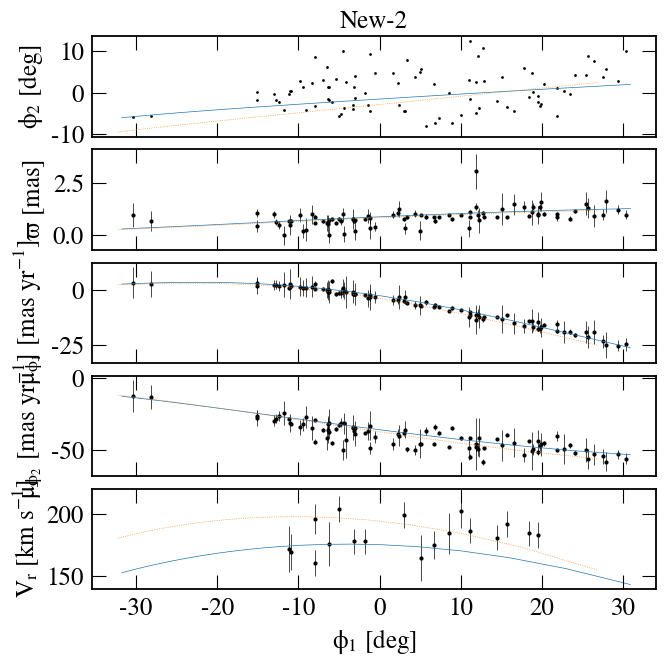

In [924]:
# plot
p = pickle.load(open('../data/orbits/fits/{:s}.pkl'.format(stream), 'rb'))
ind_segment = ((p['orbit_fr'].phi1.wrap_at(wangle)<np.max(p['c_fr'].phi1.wrap_at(wangle)) + 2*u.deg)
               & (p['orbit_fr'].phi1.wrap_at(wangle)>np.min(p['c_fr'].phi1.wrap_at(wangle)) - 2*u.deg)
              & (p['orbit_fr'].phi2<np.max(p['c_fr'].phi2) + 5*u.deg)
              & (p['orbit_fr'].phi2>np.min(p['c_fr'].phi2) - 5*u.deg))
ind0 = ((orbit0_fr.phi1.wrap_at(wangle)<np.max(p['c_fr'].phi1.wrap_at(wangle)) + 2*u.deg)
        & (orbit0_fr.phi1.wrap_at(wangle)>np.min(p['c_fr'].phi1.wrap_at(wangle)) - 2*u.deg)
        & (orbit0_fr.phi2<np.max(p['c_fr'].phi2) + 5*u.deg)
        & (orbit0_fr.phi2>np.min(p['c_fr'].phi2) - 5*u.deg))

plt.close()
fig, ax = plt.subplots(5,1, figsize=(7,7), sharex=True)

plt.sca(ax[0])
plt.plot(p['c_fr'].phi1.wrap_at(wangle), p['c_fr'].phi2, 'ko', mew=0, ms=2, zorder=0)
plt.plot(p['orbit_fr'].phi1.wrap_at(wangle)[ind_segment], p['orbit_fr'].phi2[ind_segment], '-', lw=0.5)
plt.plot(orbit0_fr.phi1.wrap_at(wangle)[ind0], orbit0_fr.phi2[ind0], ':', lw=0.5)

# plt.plot(p['orbit_fr'].phi1.wrap_at(wangle), p['orbit_fr'].phi2, '-', lw=0.5)
# plt.plot(orbit0_fr.phi1.wrap_at(wangle), orbit0_fr.phi2, ':', lw=0.5)

plt.title(stream, fontsize='medium')

plt.sca(ax[1])
ind_dist = p['c_fr'].distance<300*u.kpc
plt.errorbar(p['c_fr'].phi1.wrap_at(wangle)[ind_dist], p['obj_data']['parallax'][ind_dist],
             yerr=p['obj_data']['parallax_error'][ind_dist], color='k', fmt='o', mew=0, ms=3, lw=0.5, zorder=0)
plt.plot(p['orbit_fr'].phi1.wrap_at(wangle)[ind_segment], p['orbit_fr'].distance.parallax.to(u.mas)[ind_segment],
         '-', lw=0.5, zorder=1)
plt.plot(orbit0_fr.phi1.wrap_at(wangle)[ind0], orbit0_fr.distance.parallax.to(u.mas)[ind0], ':', lw=0.5, zorder=2)

plt.sca(ax[2])
plt.errorbar(p['c_fr'].phi1.wrap_at(wangle), p['c_fr'].pm_phi1_cosphi2.value,
             yerr=p['obj_data']['pm_phi1_cosphi2_error'], color='k', fmt='o', mew=0, ms=3, lw=0.5, zorder=0)
plt.plot(p['orbit_fr'].phi1.wrap_at(wangle)[ind_segment], p['orbit_fr'].pm_phi1_cosphi2[ind_segment],
         '-', lw=0.5, zorder=1)
plt.plot(orbit0_fr.phi1.wrap_at(wangle)[ind0], orbit0_fr.pm_phi1_cosphi2[ind0], ':', lw=0.5)

plt.sca(ax[3])
plt.errorbar(p['c_fr'].phi1.wrap_at(wangle), p['c_fr'].pm_phi2.value,
             yerr=p['obj_data']['pm_phi2_error'], color='k', fmt='o', mew=0, ms=3, lw=0.5, zorder=0)
plt.plot(p['orbit_fr'].phi1.wrap_at(wangle)[ind_segment], p['orbit_fr'].pm_phi2[ind_segment],
         '-', lw=0.5, zorder=1)
plt.plot(orbit0_fr.phi1.wrap_at(wangle)[ind0], orbit0_fr.pm_phi2[ind0], ':', lw=0.5)

plt.sca(ax[4])
plt.errorbar(p['c_fr'].phi1.wrap_at(wangle), p['c_fr'].radial_velocity.value,
             yerr=p['obj_data']['radial_velocity_error'], color='k', fmt='o', mew=0, ms=3, lw=0.5, zorder=0)
plt.plot(p['orbit_fr'].phi1.wrap_at(wangle)[ind_segment], p['orbit_fr'].radial_velocity[ind_segment],
         '-', lw=0.5, zorder=1)
plt.plot(orbit0_fr.phi1.wrap_at(wangle)[ind0], orbit0_fr.radial_velocity[ind0], ':', lw=0.5)

plt.xlabel('$\phi_1$ [deg]')

for i in range(5):
    plt.sca(ax[i])
    plt.ylabel(row_labels[i])

plt.tight_layout(h_pad=0)

### Test

In [275]:
# test
stream = 'Sagittarius'
tin = Table.read('../data/members/streams/{:s}.fits'.format(stream))

In [276]:
tin

source_id,dist,dist_err,Vr,Vr_err,FeH,FeH_err,aFe,aFe_err,p_mem,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,name,reference
,kpc,kpc,km / s,km / s,[-],[-],,,,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes11,bytes12
219219426355200,28.02,2.36,-117.35,0.72,-1.02,0.03,--,--,--,45.307580405564345,0.03480265,1.1279382416890051,0.030160492,-0.010089237772601196,0.039964005,-0.25245813,1.6668926,0.1023986748476843,0.044851113,-1.6637444742819107,0.035731785,0.055064853,-0.023295205,-0.049490687,0.06501336,-0.33140874,0.06978142,-0.08805532,-0.021391943,0.03197016,0.09185303,Sagittarius,Vasiliev2021
364281946252288,28.02,2.66,-131.12,1.95,-0.49,0.08,--,--,--,44.13025632626684,0.0993535,1.1877060240269255,0.09700808,-0.06919046437677628,0.13177064,-0.5250826,2.3027973,-0.07547459971028393,0.12066789,-2.3015602282698087,0.109266795,-0.003470617,0.252567,0.07594189,0.071712874,-0.45018327,-0.043226894,0.016780945,0.23018412,0.012818487,0.2508617,Sagittarius,Vasiliev2021
372974960167808,28.02,2.66,--,--,--,--,--,--,--,43.84412551445493,0.05087341,1.2017192077002323,0.045604225,0.08397620213039428,0.058640152,1.4320598,2.0641568,-0.07092602257556095,0.06338759,-2.062937812162532,0.06023525,0.036304705,0.2818297,-0.042360187,-0.07932633,-0.1948007,-0.050162263,-0.046174176,0.04403912,-0.14101885,0.1651712,Sagittarius,Vasiliev2021
454033878448384,27.9,2.17,--,--,--,--,--,--,--,44.949358890591256,0.044924896,1.6591056888465487,0.03955651,0.007978737979692355,0.0546911,0.14588732,2.2431462,-0.11180743709294902,0.05550937,-2.240358006422948,0.049473535,-0.024596188,0.2878837,-0.18071494,0.06929622,-0.33114734,0.09988988,0.011225898,0.08692924,-0.15765303,0.16926579,Sagittarius,Vasiliev2021
495055110557696,27.9,2.17,--,--,--,--,--,--,--,44.71505501298046,0.036202542,1.5865234675953002,0.037404846,-0.01141287156821577,0.049111843,-0.23238532,1.884062,0.024062084811890053,0.045487456,-1.8839083825353273,0.044301767,0.0418726,0.19915682,-0.09149136,0.024855733,-0.49069592,-0.034619108,-0.25892457,0.008077055,0.28515604,0.18014203,Sagittarius,Vasiliev2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6855806950283324672,21.22,4.25,--,--,--,--,--,--,--,309.0214184083491,0.040308133,-21.992306733204792,0.027422044,0.08017276232533804,0.049960095,1.604736,3.4952145,-2.4825808741965245,0.050860994,-2.4603489618833922,0.037179947,0.35619667,-0.099032834,0.055190165,-0.15670465,-0.0022443358,-0.13222684,0.2650869,-0.38726383,-0.25928655,0.44264397,Sagittarius,Vasiliev2021
6856132302645056000,22.68,4.91,--,--,--,--,--,--,--,307.95960706769915,0.1130857,-21.373083954429582,0.0782444,-0.07774023712689491,0.13867639,-0.5605874,3.4456282,-2.6593766881812106,0.13521893,-2.1909061041817197,0.09768369,0.42132422,0.08300409,-0.17229791,-0.17802809,-0.09543867,-0.15200676,0.21899015,-0.31335968,-0.347443,0.40181077,Sagittarius,Vasiliev2021


In [277]:
gin = GaiaData(tin, radial_velocity_colname='Vr', radial_velocity_error_colname='Vr_err')

In [278]:
frame = mwstreams[dict_invgalstreams[stream]].stream_frame

In [303]:
data = run_orbit_fit(gin, frame)

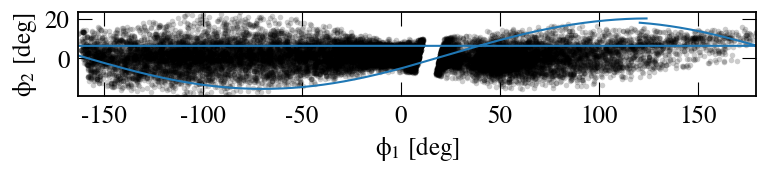

In [308]:
plt.plot(data['c_fr'].phi1, data['c_fr'].phi2, 'ko', mew=0, ms=4, alpha=0.2)
plt.plot(data['orbit_fr'].phi1.wrap_at(180*u.deg), data['orbit_fr'].phi2, '-')

plt.xlim(np.min(data['c_fr'].phi1.value), np.max(data['c_fr'].phi1.value))
plt.ylim(np.min(data['c_fr'].phi2.value), np.max(data['c_fr'].phi2.value))
plt.gca().set_aspect('equal')

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')

plt.tight_layout()

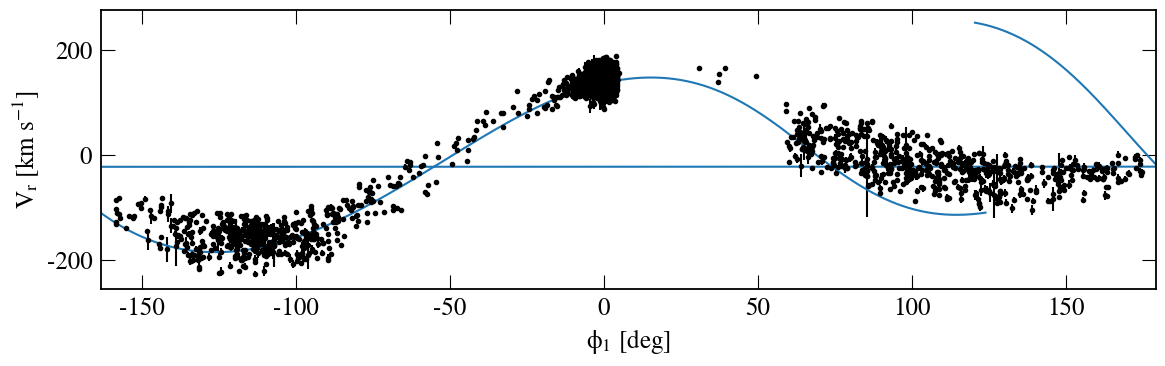

In [305]:
plt.figure(figsize=(12,4))

plt.errorbar(data['c_fr'].phi1, tin['Vr'], yerr=tin['Vr_err'], color='k', fmt='.')
orbit_eq = data['orbit'].to_coord_frame(coord.ICRS())
plt.plot(data['orbit_fr'].phi1, orbit_eq.radial_velocity, '-')

plt.xlim(np.min(data['c_fr'].phi1.value), np.max(data['c_fr'].phi1.value))

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$V_r$ [km s$^{-1}$]')

plt.tight_layout()

### Run all streams

In [319]:
nstart = 2
for e, stream in enumerate(published[nstart:]):
    print(nstart+e, stream)
    t1 = time.time()
    
    # load data
    tin = Table.read('../data/members/unique/{:s}.fits'.format(stream))
    gin = GaiaData(tin, radial_velocity_colname='Vr', radial_velocity_error_colname='Vr_err')
    frame = mwstreams[dict_invgalstreams[stream]].stream_frame
    
    # get orbit
    data = run_orbit_fit(gin, frame)
    
    # store orbit
    with open('../data/orbits/fits/{:s}.pkl'.format(stream), 'wb') as f:
        pickle.dump(data, f)
    
    t2 = time.time()
    dt = (t2 - t1)*u.s
    print('{:d} {:.0f}'.format(len(tin), dt))

2 C-10
158 50 s
3 C-11
112 55 s
4 C-12
929 60 s
5 C-13
100 156 s
6 C-19
46 170 s
7 C-20
29 52 s
8 C-22
39 45 s
9 C-23
29 67 s
10 C-24
244 121 s
11 C-25
121 52 s
12 C-7
239 108 s
13 C-9
183 35 s
14 Cetus-Palca
25 180 s
15 Elqui
17 96 s
16 GD-1
1478 62 s
17 Gaia-1
200 64 s
18 Gaia-11
84 103 s
19 Gaia-12
46 37 s
20 Gaia-6
145 117 s
21 Gaia-7
282 36 s
22 Gaia-8
453 65 s
23 Gaia-9
233 35 s
24 Hrid
666 72 s
25 Hydrus
39 145 s
26 Indus
1032 121 s
27 Jet
144 111 s
28 Jhelum
993 70 s
29 Kshir
141 138 s
30 Kwando
138 91 s
31 Wukong
358 110 s
32 Leiptr
412 64 s
33 M2
136 333 s
34 M3
237 1156 s
35 M30
54 1360 s
36 M5
128 240 s
37 M68
297 140 s
38 M92
202 122 s
39 NGC 1261
174 144 s
40 NGC 1851
105 234 s
41 NGC 2298
125 82 s
42 NGC 2808
292 166 s
43 NGC 288
173 102 s
44 NGC 3201
607 152 s
45 NGC 5466
43 92 s
46 NGC 5824
27 64 s
47 NGC 6101
94 122 s
48 NGC 6397
1207 139 s
49 NGC 7492
26 77 s
50 New-1
11 47 s
51 New-10
47 17 s
52 New-11
18 37 s
53 New-12
89 80 s
54 New-13
47 43 s
55 New-14
18 23 s
56

### Diagnostic plots

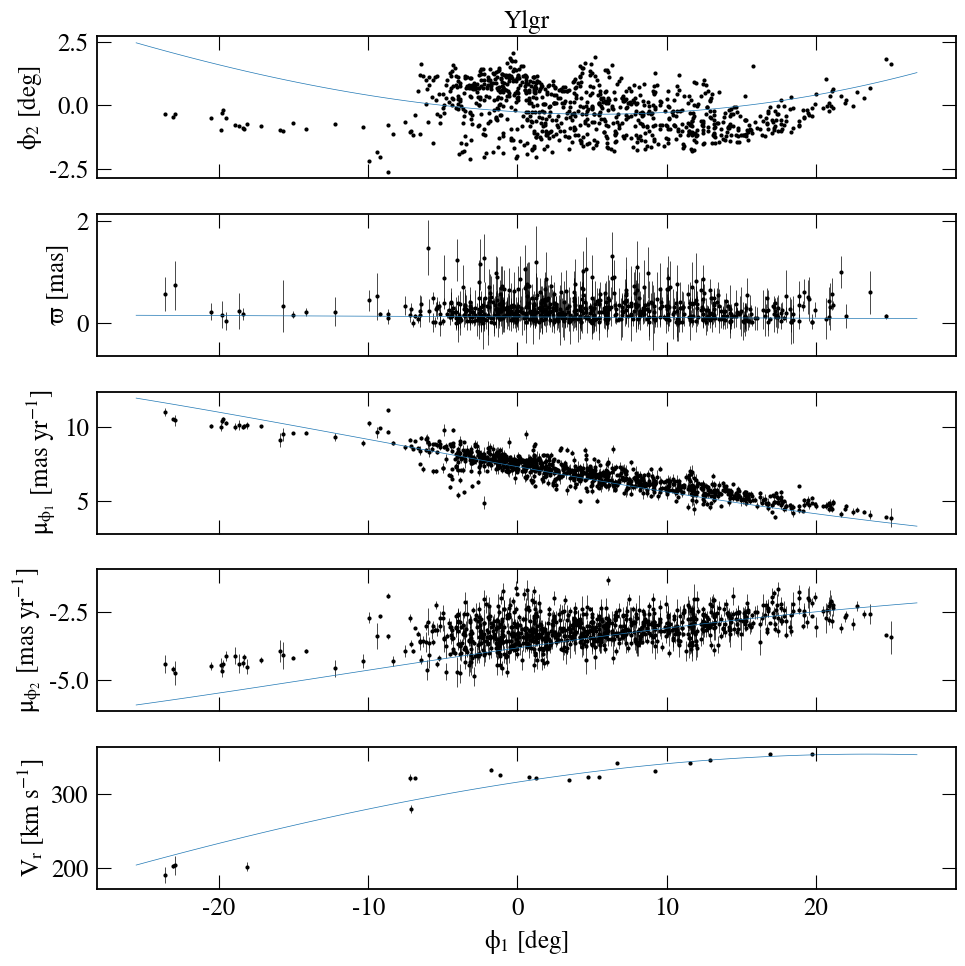

In [354]:
# individual stream orbit fits
wangle = 180*u.deg
row_labels = ['$\phi_2$ [deg]', '$\\varpi$ [mas]', '$\mu_{\phi_1}$ [mas yr$^{-1}$]', '$\mu_{\phi_2}$ [mas yr$^{-1}$]',
             '$V_r$ [km s$^{-1}$]']

pp = PdfPages('../plots/orbit_fits_diagnostics.pdf')

for stream in published[:]:
    p = pickle.load( open('../data/orbits/fits/{:s}.pkl'.format(stream), 'rb'))
    ind_segment = ((p['orbit_fr'].phi1.wrap_at(wangle)<np.max(p['c_fr'].phi1.wrap_at(wangle)) + 2*u.deg)
                   & (p['orbit_fr'].phi1.wrap_at(wangle)>np.min(p['c_fr'].phi1.wrap_at(wangle)) - 2*u.deg)
                  & (p['orbit_fr'].phi2<np.max(p['c_fr'].phi2) + 2*u.deg)
                  & (p['orbit_fr'].phi2>np.min(p['c_fr'].phi2) - 2*u.deg))
    
    plt.close()
    fig, ax = plt.subplots(5,1, figsize=(10,10), sharex=True)
    
    plt.sca(ax[0])
    plt.plot(p['c_fr'].phi1.wrap_at(wangle), p['c_fr'].phi2, 'ko', mew=0, ms=3)
    plt.plot(p['orbit_fr'].phi1.wrap_at(wangle)[ind_segment], p['orbit_fr'].phi2[ind_segment], '-', lw=0.5)
    plt.title(stream, fontsize='medium')
    
    plt.sca(ax[1])
    ind_dist = p['c_fr'].distance<300*u.kpc
    plt.errorbar(p['c_fr'].phi1.wrap_at(wangle)[ind_dist], p['obj_data']['parallax'][ind_dist],
                 yerr=p['obj_data']['parallax_error'][ind_dist], color='k', fmt='o', mew=0, ms=3, lw=0.5, zorder=0)
    plt.plot(p['orbit_fr'].phi1.wrap_at(wangle)[ind_segment], p['orbit_fr'].distance.parallax.to(u.mas)[ind_segment],
             '-', lw=0.5, zorder=1)
    
    plt.sca(ax[2])
    plt.errorbar(p['c_fr'].phi1.wrap_at(wangle), p['c_fr'].pm_phi1_cosphi2.value,
                 yerr=p['obj_data']['pm_phi1_cosphi2_error'], color='k', fmt='o', mew=0, ms=3, lw=0.5, zorder=0)
    plt.plot(p['orbit_fr'].phi1.wrap_at(wangle)[ind_segment], p['orbit_fr'].pm_phi1_cosphi2[ind_segment],
             '-', lw=0.5, zorder=1)
    
    plt.sca(ax[3])
    plt.errorbar(p['c_fr'].phi1.wrap_at(wangle), p['c_fr'].pm_phi2.value,
                 yerr=p['obj_data']['pm_phi2_error'], color='k', fmt='o', mew=0, ms=3, lw=0.5, zorder=0)
    plt.plot(p['orbit_fr'].phi1.wrap_at(wangle)[ind_segment], p['orbit_fr'].pm_phi2[ind_segment],
             '-', lw=0.5, zorder=1)
    
    plt.sca(ax[4])
    plt.errorbar(p['c_fr'].phi1.wrap_at(wangle), p['c_fr'].radial_velocity.value,
                 yerr=p['obj_data']['radial_velocity_error'], color='k', fmt='o', mew=0, ms=3, lw=0.5, zorder=0)
    plt.plot(p['orbit_fr'].phi1.wrap_at(wangle)[ind_segment], p['orbit_fr'].radial_velocity[ind_segment],
             '-', lw=0.5, zorder=1)
    plt.xlabel('$\phi_1$ [deg]')
    
    for i in range(5):
        plt.sca(ax[i])
        plt.ylabel(row_labels[i])
    
    plt.tight_layout()
    pp.savefig()
    
pp.close()

In [385]:
pall = pickle.load( open('../data/stream-orbit-fits.pkl', 'rb'))
psum = pickle.load( open('../data/all_stream_summary_data.pkl', 'rb'))

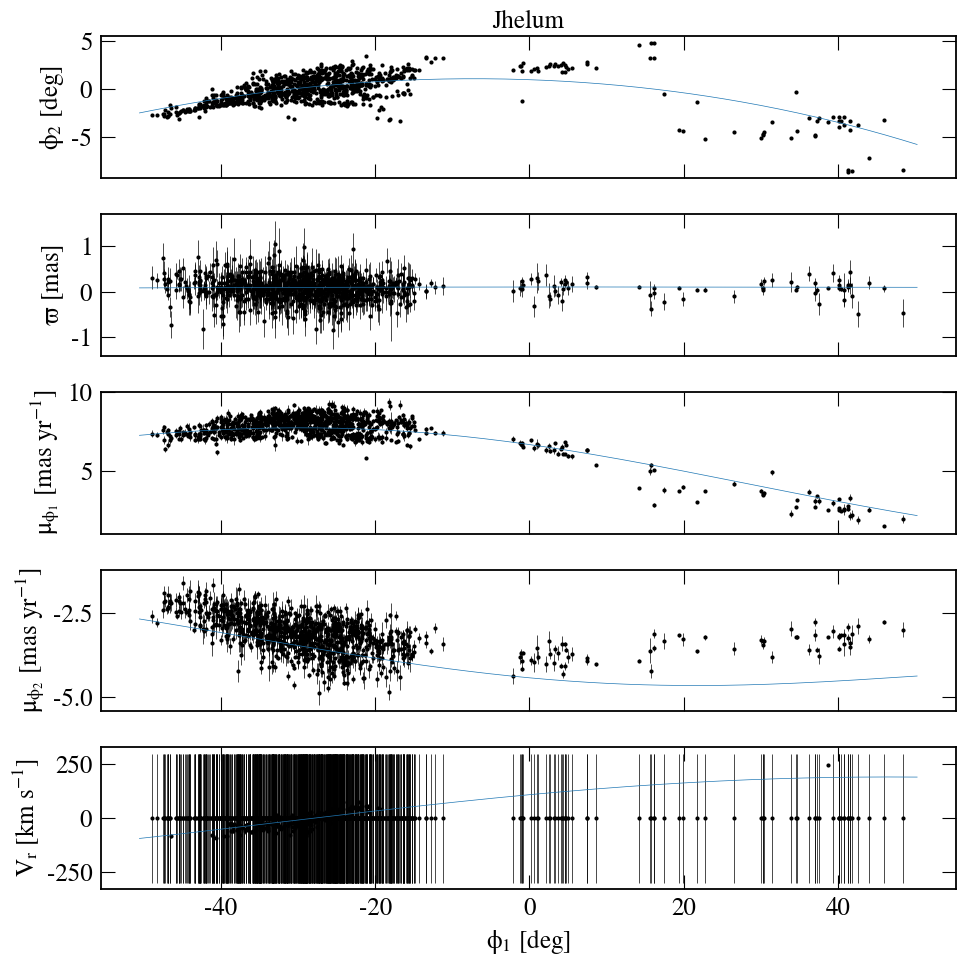

In [402]:
# OLD individual stream orbit fits
wangle = 180*u.deg
row_labels = ['$\phi_2$ [deg]', '$\\varpi$ [mas]', '$\mu_{\phi_1}$ [mas yr$^{-1}$]', '$\mu_{\phi_2}$ [mas yr$^{-1}$]',
             '$V_r$ [km s$^{-1}$]']

pp = PdfPages('../plots/old_orbit_fits_diagnostics.pdf')

nold = len(pall.keys())
# nold = 2

for i in range(nold):
    if (i+1) in pall.keys():
        name = psum['name'][psum['ibata2023_sID']==i+1][0]
        p = pall[i+1]
        ind_segment = ((p['orbit_fr'].phi1.wrap_at(wangle)<np.max(p['c_fr'].phi1.wrap_at(wangle)) + 2*u.deg)
                       & (p['orbit_fr'].phi1.wrap_at(wangle)>np.min(p['c_fr'].phi1.wrap_at(wangle)) - 2*u.deg)
                      & (p['orbit_fr'].phi2<np.max(p['c_fr'].phi2) + 2*u.deg)
                      & (p['orbit_fr'].phi2>np.min(p['c_fr'].phi2) - 2*u.deg))

        plt.close()
        fig, ax = plt.subplots(5,1, figsize=(10,10), sharex=True)

        plt.sca(ax[0])
        plt.plot(p['c_fr'].phi1.wrap_at(wangle), p['c_fr'].phi2, 'ko', mew=0, ms=3)
        plt.plot(p['orbit_fr'].phi1.wrap_at(wangle)[ind_segment], p['orbit_fr'].phi2[ind_segment], '-', lw=0.5)
        plt.title(name, fontsize='medium')

        plt.sca(ax[1])
        ind_dist = p['c_fr'].distance<300*u.kpc
        plt.errorbar(p['c_fr'].phi1.wrap_at(wangle)[ind_dist], p['obj_data']['parallax'][ind_dist],
                     yerr=p['obj_data']['parallax_error'][ind_dist], color='k', fmt='o', mew=0, ms=3, lw=0.5, zorder=0)
        plt.plot(p['orbit_fr'].phi1.wrap_at(wangle)[ind_segment], p['orbit_fr'].distance.parallax.to(u.mas)[ind_segment],
                 '-', lw=0.5, zorder=1)

        plt.sca(ax[2])
        plt.errorbar(p['c_fr'].phi1.wrap_at(wangle), p['c_fr'].pm_phi1_cosphi2.value,
                     yerr=p['obj_data']['pm_phi1_cosphi2_error'], color='k', fmt='o', mew=0, ms=3, lw=0.5, zorder=0)
        plt.plot(p['orbit_fr'].phi1.wrap_at(wangle)[ind_segment], p['orbit_fr'].pm_phi1_cosphi2[ind_segment],
                 '-', lw=0.5, zorder=1)

        plt.sca(ax[3])
        plt.errorbar(p['c_fr'].phi1.wrap_at(wangle), p['c_fr'].pm_phi2.value,
                     yerr=p['obj_data']['pm_phi2_error'], color='k', fmt='o', mew=0, ms=3, lw=0.5, zorder=0)
        plt.plot(p['orbit_fr'].phi1.wrap_at(wangle)[ind_segment], p['orbit_fr'].pm_phi2[ind_segment],
                 '-', lw=0.5, zorder=1)

        plt.sca(ax[4])
        plt.errorbar(p['c_fr'].phi1.wrap_at(wangle), p['c_fr'].radial_velocity.value,
                     yerr=p['obj_data']['radial_velocity_error'], color='k', fmt='o', mew=0, ms=3, lw=0.5, zorder=0)
        plt.plot(p['orbit_fr'].phi1.wrap_at(wangle)[ind_segment], p['orbit_fr'].radial_velocity[ind_segment],
                 '-', lw=0.5, zorder=1)
        plt.xlabel('$\phi_1$ [deg]')

        for i in range(5):
            plt.sca(ax[i])
            plt.ylabel(row_labels[i])

        plt.tight_layout()
        pp.savefig()
    
pp.close()

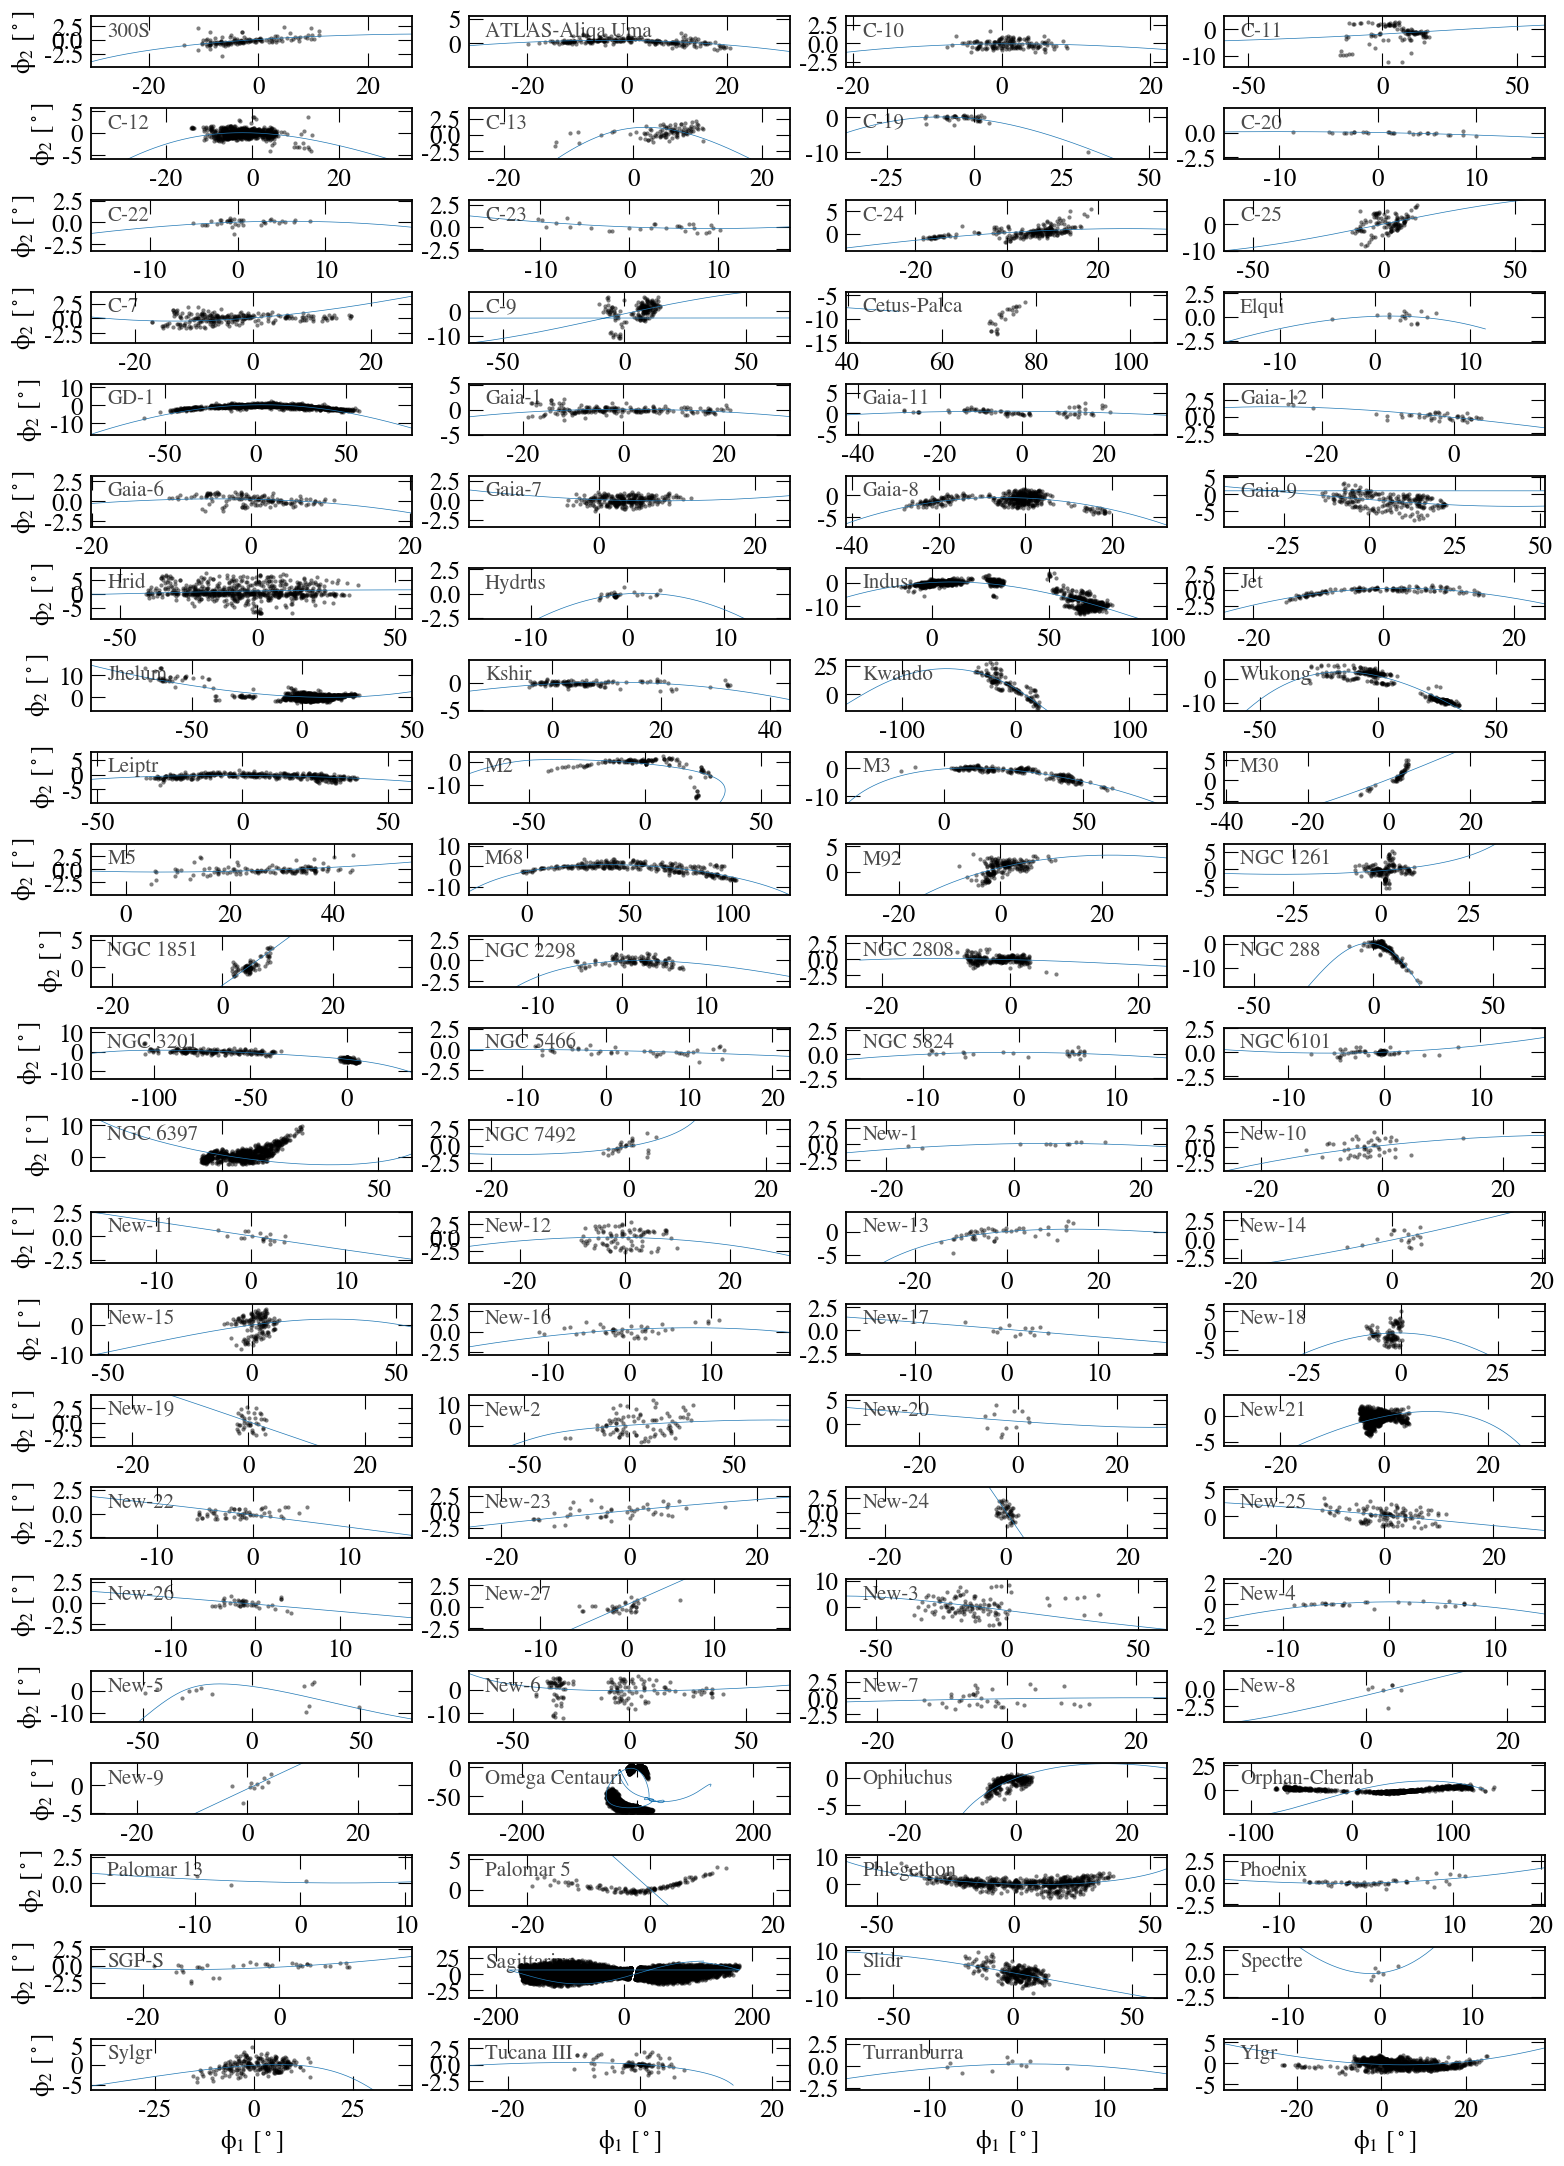

In [323]:
# summary figure
# set up figure geometry
nstream = len(published)
ncol = 4
nrow = int(np.ceil(nstream/ncol))
print(nstream, nrow, ncol)

fig, ax = plt.subplots(nrow, ncol, figsize=(16,22))

for i in range(nstream):
    irow = i // ncol
    icol = i % ncol
    plt.sca(ax[irow][icol])
    
    # load stream
    stream = published[i]
    p = pickle.load( open('../data/orbits/fits/{:s}.pkl'.format(stream), 'rb'))
    
    # plot
    plt.plot(p['c_fr'].phi1.wrap_at(180*u.deg), p['c_fr'].phi2, 'ko', mew=0, ms=3, alpha=0.5, rasterized=True)
    plt.plot(p['orbit_fr'].phi1.wrap_at(180*u.deg), p['orbit_fr'].phi2, '-', lw=0.5)
    
    plt.xlim(np.min(p['c_fr'].phi1.value)-2, np.max(p['c_fr'].phi1.value)+2)
    plt.ylim(np.min(p['c_fr'].phi2.value)-2, np.max(p['c_fr'].phi2.value)+2)
    plt.gca().set_aspect('equal', adjustable='datalim')
    plt.text(0.05, 0.9, published[i], transform=plt.gca().transAxes, va='top', fontsize='small', alpha=0.7)

# labels
for i in range(nrow):
    plt.sca(ax[i][0])
    plt.ylabel('$\phi_2$ [$^\circ$]')

for i in range(ncol):
    plt.sca(ax[nrow-1][i])
    plt.xlabel('$\phi_1$ [$^\circ$]')

# plt.sca(ax[nrow-1][ncol-1])
# plt.axis('off')
# plt.text(0.5, 1, '$\phi_1$ [$^\circ$]', transform=plt.gca().transAxes, va='top', ha='center')
    
plt.tight_layout(h_pad=0, w_pad=0)
plt.savefig('../plots/all_members_sky_orbit.png', dpi=300)

In [96]:
torb = Table.read('../data/summary_stream_orbits.fits')

In [97]:
torb

sID,name,nstar,rperi,rapo,ecc,etot,lx,ly,lz,lperp,lmax,circlz
float64,bytes20,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1.0,C-20,29,23.485256609097632,144.44760103008662,0.7203018284896052,-0.04020841033763155,7.66518678288009,1.9555200905134915,-3.5641710081506695,7.910698277702261,15.961329593562922,0.22330038279443032
2.0,New-1,36,12.160134293212584,49.21909955021514,0.6037704112035067,-0.07350886330655818,3.5822776792197244,0.9767718803447158,-2.270703126907051,3.71305759142893,6.680145924782878,0.33991819227824044
3.0,NGC288,173,2.938592932401875,13.641652535373339,0.6455308290684573,-0.13000325432593926,-0.7667672442513338,0.15052395716218353,0.6068879307203449,0.7814022450291191,2.086292606140266,0.2908930074976945
4.0,ATLAS,208,12.304691837953808,37.20146399306654,0.5029025529692314,-0.08268745388669722,3.6009520949795655,-0.36879173418885847,-1.8621511284840129,3.6197877470293403,5.421724681420122,0.34346102723833927
5.0,Phoenix,58,12.204027812388059,17.84853266528946,0.1878210962122191,-0.1054481414885668,1.3571410861351971,2.2919736188200877,-1.5875673409586264,2.663639426995229,3.34349322505306,0.47482295733781016
6.0,Kwando,138,28.841827819574426,56.192147695193526,0.32163990581469565,-0.06271218176398591,6.3374703201351705,3.6200817321695977,-2.7995433060046726,7.298528742574233,8.649459255747148,0.3236668586125209
...,...,...,...,...,...,...,...,...,...,...,...,...
82.0,New-27,43,4.59388072776457,15.719360942354397,0.5476959510089199,-0.12176515248459674,0.2353208372624964,-0.4448679595025139,-1.6182075531257345,0.503272687359301,2.4316235181394172,0.6654844144474813
83.0,New-28,37,38.64171234196378,--,--,0.7642893072499177,-47.234425241905065,-2.823756821439648,-17.421864006158014,47.318754532634784,72073.86276778292,0.00024172235727520355
